# Assignment 5

**Deadline**:  09/10/2019, 9.59am

**Names and student numbers:**
1. Vien Dinh (11002115)
2. Dante van der Heijden (11020075)
3. Jorrim Prins (11038934)

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:
1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.

## Instructions for completing and submitting the assignment
Please pay attention to the following instructions:
1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.
4. You are allowed to work on the assignment in groups of 2 or 3 students and to submit together. Before you submit, you and your team members have to register as an **Assignment group** on Canvas. Only a single member of each group has to submit the notebook. Please do **NOT** submit the same notebook multiple times!
5. Please write your names also inside this markdown cell, under **Names and student numbers**.

# IMPORTANT: RESTRICTION ON ALLOWED LIBRARIES!!!
You are **NOT** allowed to use any scikit-learn models and functions, except the function `Kfold`. Material from the computer classes, including the solutions, can be used and copied freely and without penalty.

**Exercise 1:** import the relevant libraries. Keep in mind that you are not allowed to use any scikit-learn models and functions, except the function `Kfold`.

In [1]:
#Import the relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

**Example:** the file `DSM_assignment5_features.csv` contains the features (of float type) of 300 observations. The file `DSM_assignment5_classes.csv` contains the corresponding classes (of string type). We are loading the features as a 2-dimensional array and the classes as a 1-dimensional array and call them `X` and `y`, respectively.

In [2]:
#Load data
X = np.loadtxt("DSM_assignment5_features.csv", delimiter=',')
y = np.loadtxt("DSM_assignment5_classes.csv", delimiter=',', dtype=np.str)

**Exercise 2:** create a sensible and clear visualization of the data, showing the different classes and how they are located in feature space.

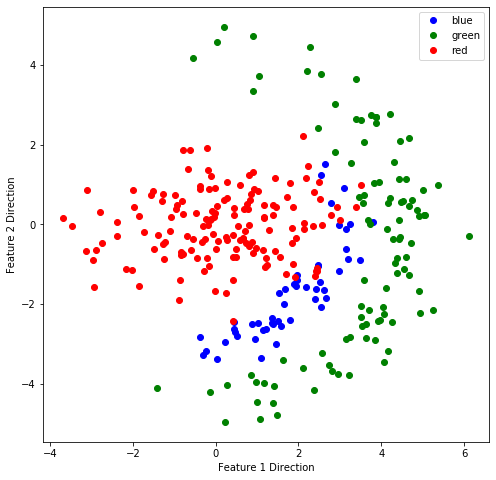

In [3]:
#Visualise data
df = pd.DataFrame(dict(x1 = X[:,0], x2= X[:,1], colors = y))
grouper = df.groupby('colors')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
for name, group in grouper:
    ax.plot(group.x1, group.x2, marker='o', linestyle='', label=name, color=name)
ax.legend()
ax.set_xlabel("Feature 1 Direction")
ax.set_ylabel("Feature 2 Direction")

plt.show()

**Exercise 3:** use Linear Discriminant Analysis (LDA) to determine the prediction regions, based on the classification dataset given by `X` and `y`. Your solution should consist of three parts:
* implementation of the method (i.e. writing a training function that trains a model using this method and returns a predictor function).
* visualization of the prediction regions. 
    
* evaluation of the model performance, using **both** the prediction accuracy and a confusion matrix.

In [4]:
# First we determine the unique class names, indices and transform y to be either 0, 1 or 2.
K_class_names, indices, y = np.unique(y, return_inverse=True, return_index=True)
K_classes = len(K_class_names)

In [5]:
# We determine functions for the accuracy and confusion matrix
def accuracy(training_method, X, y, K_classes, K_cv=10, runs=1):
    
    N = len(y)
    
    misclassifications = np.array([])
    for run in range(runs):
        
        cv_folds = KFold(n_splits=K_cv, shuffle=True) # Randomly creating new folds for each run
        
        for indices_train, indices_test in cv_folds.split(X):
            
            X_train = X[indices_train]
            y_train = y[indices_train]
            X_test = X[indices_test]
            y_test = y[indices_test]

            G_fitted = training_method(X_train, y_train, K_classes) # Fitting model in training data
            y_fitted_test = G_fitted(X_test) # Using fitted model to predict on test data

            no_misclassifications = np.sum(y_fitted_test != y_test) # Counting number of prediction errors test data
            misclassifications = np.append(misclassifications, no_misclassifications)
    
    accuracy = 1 - np.sum(misclassifications)/(N*runs)
    std_error = np.std(misclassifications, ddof=1)*np.sqrt(K_cv/runs)/N
    
    return accuracy, std_error

def confusion(training_method, X, y, K_classes, K_cv=10, runs=1):
    
    misclassifications = np.array([])
    
    conf_mat = pd.DataFrame(np.zeros((K_classes,K_classes)).astype(int), index=K_class_names, columns=K_class_names)
    conf_mat.columns.name = 'Actual class:'
    conf_mat.index.name = 'Predicted class:'
    
    for run in range(runs):
        
        cv_folds = KFold(n_splits=K_cv, shuffle=True) # Randomly creating new folds for each run
        
        for indices_train, indices_test in cv_folds.split(X):
            
            X_train = X[indices_train]
            y_train = y[indices_train]
            X_test = X[indices_test]
            y_test = y[indices_test]

            G_fitted = training_method(X_train, y_train, K_classes) # Fitting model in training data

            y_fitted_test = G_fitted(X_test) # Using fitted model to predict on test data
            
            for y_predicted, y_actual in zip(y_fitted_test, y_test):            
                conf_mat.iloc[y_predicted, y_actual] += 1
            
    return conf_mat/runs

In [6]:
# Use only y to detect ratio of a class, pi
def get_prior_probs(y):
    
    N = len(y)
    freqs = np.unique(y, return_counts = True)[1]
    
    return freqs/N

# Find mu as matrix with rows K and columns amount of features with mean of features per class 
def get_centroids(X, y, K_classes):
    
    centroids = np.zeros((K_classes, X.shape[1]))
    
    for k in range(K_classes):  
        centroids[k] = np.mean(X[y==k], axis = 0)
        
    
    return centroids.reshape(K_classes, -1)

# Find the 2 by 2 covariance matrix which is the same per class
def get_total_covariance_matrix(X, y, K_classes, centroids):
    
    N = len(y)
    X_diff = X - np.array([centroids[k] for k in y])
    
    return (X_diff.T @ X_diff)/(N-K_classes)

centroids = get_centroids(X, y, K_classes)

# Obtain the delta
def train_lda_classification(X, y, K_classes):
    
    probs = get_prior_probs(y)
    centroids = get_centroids(X, y, K_classes)
    cov = get_total_covariance_matrix(X, y, K_classes, centroids)
    inv_cov = np.linalg.inv(cov)
    
    def G(X_new):
        
        deltas = np.zeros((X_new.shape[0], K_classes))
        for k in range(K_classes):
            deltas[:,k] = (X_new - centroids[k]/2) @ inv_cov @ centroids[k] + np.log(probs[k])
        
        return np.argmax(deltas, axis=1)
    
    return G

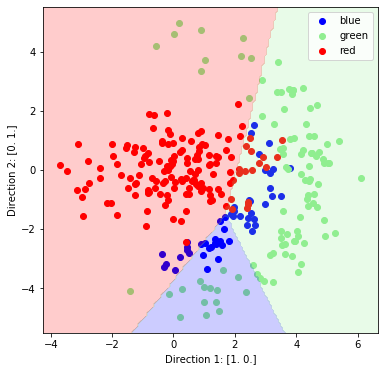

In [7]:
#Define function to plot data with prediction regions
def plot_classification(X, y, K, dir1, dir2, G=None, title=None, labels=K_class_names):
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)
    if title:
        ax.set_title(title)
    colors = ['blue', 'lightgreen', 'red']
    
    if np.isscalar(dir1):
        dir_temp = np.zeros(X.shape[1])
        dir_temp[dir1] = 1.
        dir1 = dir_temp    
    if np.isscalar(dir2):
        dir_temp = np.zeros(X.shape[1])
        dir_temp[dir2] = 1.
        dir2 = dir_temp
    dir1 = dir1/np.linalg.norm(dir1)
    dir2 = dir2/np.linalg.norm(dir2)
    
    # Plotting the observations in the data set
    for k in range(K):
        boolean_index = y==k
        ax.scatter(np.dot(X[boolean_index], dir1), np.dot(X[boolean_index], dir2), c=colors[k], label=labels[k])    
    
    # Creating classification regions
    if G:
        points = 150
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        x_range = np.linspace(xmin, xmax, points)
        y_range = np.linspace(ymin, ymax, points)
        xx, yy = np.meshgrid(x_range, y_range)
    
        G_grid = G(np.outer(xx,dir1) + np.outer(yy,dir2)).reshape(points,points)
    
        ax.contourf(x_range, y_range, G_grid, 2, alpha=.2, colors=colors)
    
    ax.set_xlabel("Direction 1: {}".format(dir1))
    ax.set_ylabel("Direction 2: {}".format(dir2))

    ax.legend();
    
plot_classification(X, y, K_classes, 0, 1, G=train_lda_classification(X, y, K_classes))

In [8]:
#Create accuracy with standard error and confusion matrix
acc_lda = accuracy(train_lda_classification, X, y, K_classes, K_cv=10, runs=10)
conf_lda = confusion(train_lda_classification, X, y, K_classes, K_cv=10, runs=10)

acc_lda, conf_lda

((0.7276666666666667, 0.008342486555602905),
 Actual class:     blue  green    red
 Predicted class:                    
 blue              12.9   15.9    0.0
 green             25.6   72.2   18.1
 red               11.5   11.9  131.9)

**Exercise 4:** repeat all the three steps of **Exercise 3**, but now for Linear Discriminant Analysis, including quadratic derived features ($x_1^2$, $x_2^2$ and $x_1 x_2$).

In [9]:
#Create new variable matrix with quadratic features
X_q = np.column_stack((X, X[:,0]**2))
X_q = np.column_stack((X_q, X[:,1]**2))
X_q = np.column_stack((X_q, np.multiply(X[:,0], X[:,1])))

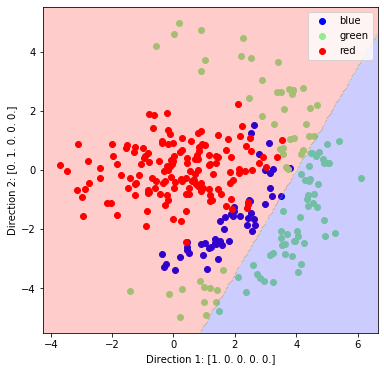

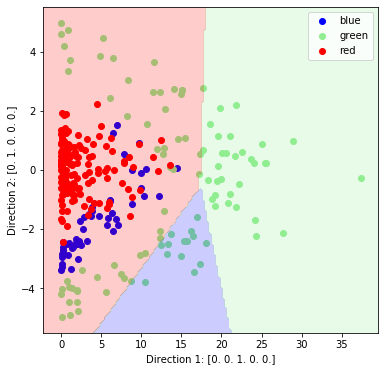

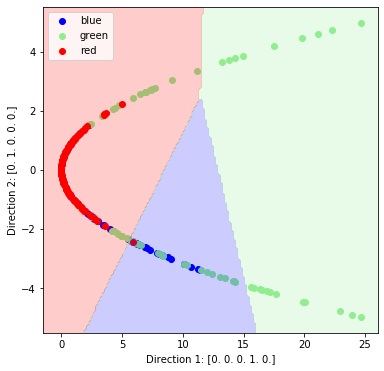

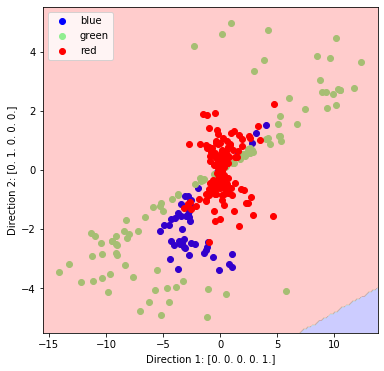

In [10]:
#Plot prediction regions for different feature spaces
for dimension in [0, 2, 3, 4]:
    plot_classification(X_q, y, K_classes, dimension, 1, G=train_lda_classification(X_q, y, K_classes))

In [11]:
acc_q_lda = accuracy(train_lda_classification, X_q, y, K_classes, K_cv=10, runs=10)
conf_q_lda = confusion(train_lda_classification, X_q, y, K_classes, K_cv=10, runs=10)

acc_q_lda, conf_q_lda

((0.923, 0.004870834431425625), Actual class:     blue  green    red
 Predicted class:                    
 blue              47.2    8.3   12.1
 green              1.0   91.7    0.4
 red                1.8    0.0  137.5)

**Exercise 5:** repeat all the three steps of **Exercise 3**, but now for Quadratic Discriminant Analysis (QDA).

In [12]:
# Find the 2 by 2 covariance matrix which is different per class
def get_per_class_covariance_matrix(X, y, K_classes, centroids):
    X_diff = X - np.array([centroids[k] for k in y])
    class_cov = []
    
    for k in range(K_classes):
        class_cov.append(np.sum(np.array([np.outer(Help, Help) for Help in X_diff[y == k]]), axis=0)/(sum(y==k)-1))
        
    return class_cov

# Obtain delta
def train_qda_classification(X, y, K_classes):

    probs = get_prior_probs(y)
    centroids = get_centroids(X, y, K_classes)
    class_cov = get_per_class_covariance_matrix(X, y, K_classes, centroids)
    inv_cov = np.linalg.inv(class_cov)
    def G(X_new):
        
        deltas = np.zeros((X_new.shape[0], K_classes))
        for k in range(K_classes):
            deltas[:,k] = np.diagonal(-((X_new - centroids[k]) @ inv_cov[k] @ (X_new - centroids[k]).T)/2 + np.log(probs[k]) - 1/2 * np.log(np.linalg.det(class_cov[k])))
        return np.argmax(deltas, axis=1)
    return G

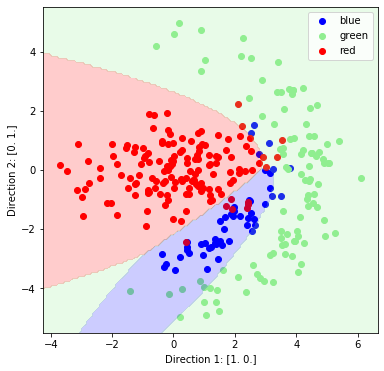

In [13]:
#Plot prediction regions for QDA
plot_classification(X, y, K_classes, 0, 1, G=train_qda_classification(X, y, K_classes))

In [14]:
#Obtain accuracy with standard error and confusion matrix
acc_qda = accuracy(train_qda_classification, X, y, K_classes, K_cv=10, runs=10)
conf_qda = confusion(train_qda_classification, X, y, K_classes, K_cv=10, runs=10)

acc_qda, conf_qda

((0.8946666666666667, 0.005987641593469991),
 Actual class:     blue  green    red
 Predicted class:                    
 blue              38.5    5.6    8.4
 green             10.5   94.4    5.9
 red                1.0    0.0  135.7)

**Exercise 6:** make, writing in the markdown cell below and using your own words, a comparison of the performance of the methods of **Exercises 3, 4 and 5**. Explain any differences and/or similarities.

## Tab A


In [15]:
acc_data = pd.DataFrame({'LDA':acc_lda,'LDA with sq+crossterm':acc_q_lda,'QDA':acc_qda}, index=["Accuracy",'Standard Error'])
totals = np.array([50, 100, 150])
acc_data

,LDA,LDA with sq+crossterm,QDA
Accuracy,0.727667,0.923000,0.894667
Standard Error,0.008342,0.004871,0.005988


## Tab B

In [16]:
conf_lda/totals, conf_q_lda/totals, conf_qda/totals

(Actual class:      blue  green       red
 Predicted class:                        
 blue              0.258  0.159  0.000000
 green             0.512  0.722  0.120667
 red               0.230  0.119  0.879333,
 Actual class:      blue  green       red
 Predicted class:                        
 blue              0.944  0.083  0.080667
 green             0.020  0.917  0.002667
 red               0.036  0.000  0.916667,
 Actual class:     blue  green       red
 Predicted class:                       
 blue              0.77  0.056  0.056000
 green             0.21  0.944  0.039333
 red               0.02  0.000  0.904667)

## Tab C

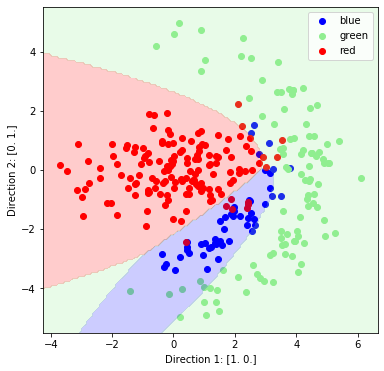

In [17]:
plot_classification(X, y, K_classes, 0, 1, G=train_qda_classification(X, y, K_classes))

Our first look at the accuracies and confusion matrices shows us the ineffectivity of the LDA method. The accuracy of LDA is significantly lower than the other two classification methods and none of the three models has a high standard error on their accuracy. (Tab A)

QDA has a way higher accuracy than LDA, but does not top the LDA method with squared and cross-terms. (Tab A) We can also look at the confusion matrices, where LDA is only a decent predictor for the class 'red' and is very bad for the class 'blue'. LDA with squared and cross-terms predicts almost all of the data correctly. The main difference between LDA with squared and cross-terms & QDA lies in the 'blue' category, where QDA scores significantly lower. (Tab B)

As the dataset only contains 50 data points within category 'blue', this might be a reason for the 'blue'-predictor to produce less accurate classifications than the other 2 categories. 

From a visual standpoint, LDA with squared and cross-terms has a disadvantage because it can not easily be plotted (as the dimension is higher than 2). We tried to visualise by combining different dimensions but it does certainly not produce clear plots as the standard LDA and QDA methods do. The QDA method is not restricted to linear region borders which results in the accurate 2D plot (Tab C) above.
